<a href="https://colab.research.google.com/github/Gholamrezadar/facial_keypoints_detection/blob/main/Facial_Keypoints_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facial Keypoints Detection
By Gholamreza Dar June 2024

In [2]:
!pip install -q timm torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.3 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import timm
from torchsummary import summary

In [4]:
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# random seed
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

## Download data

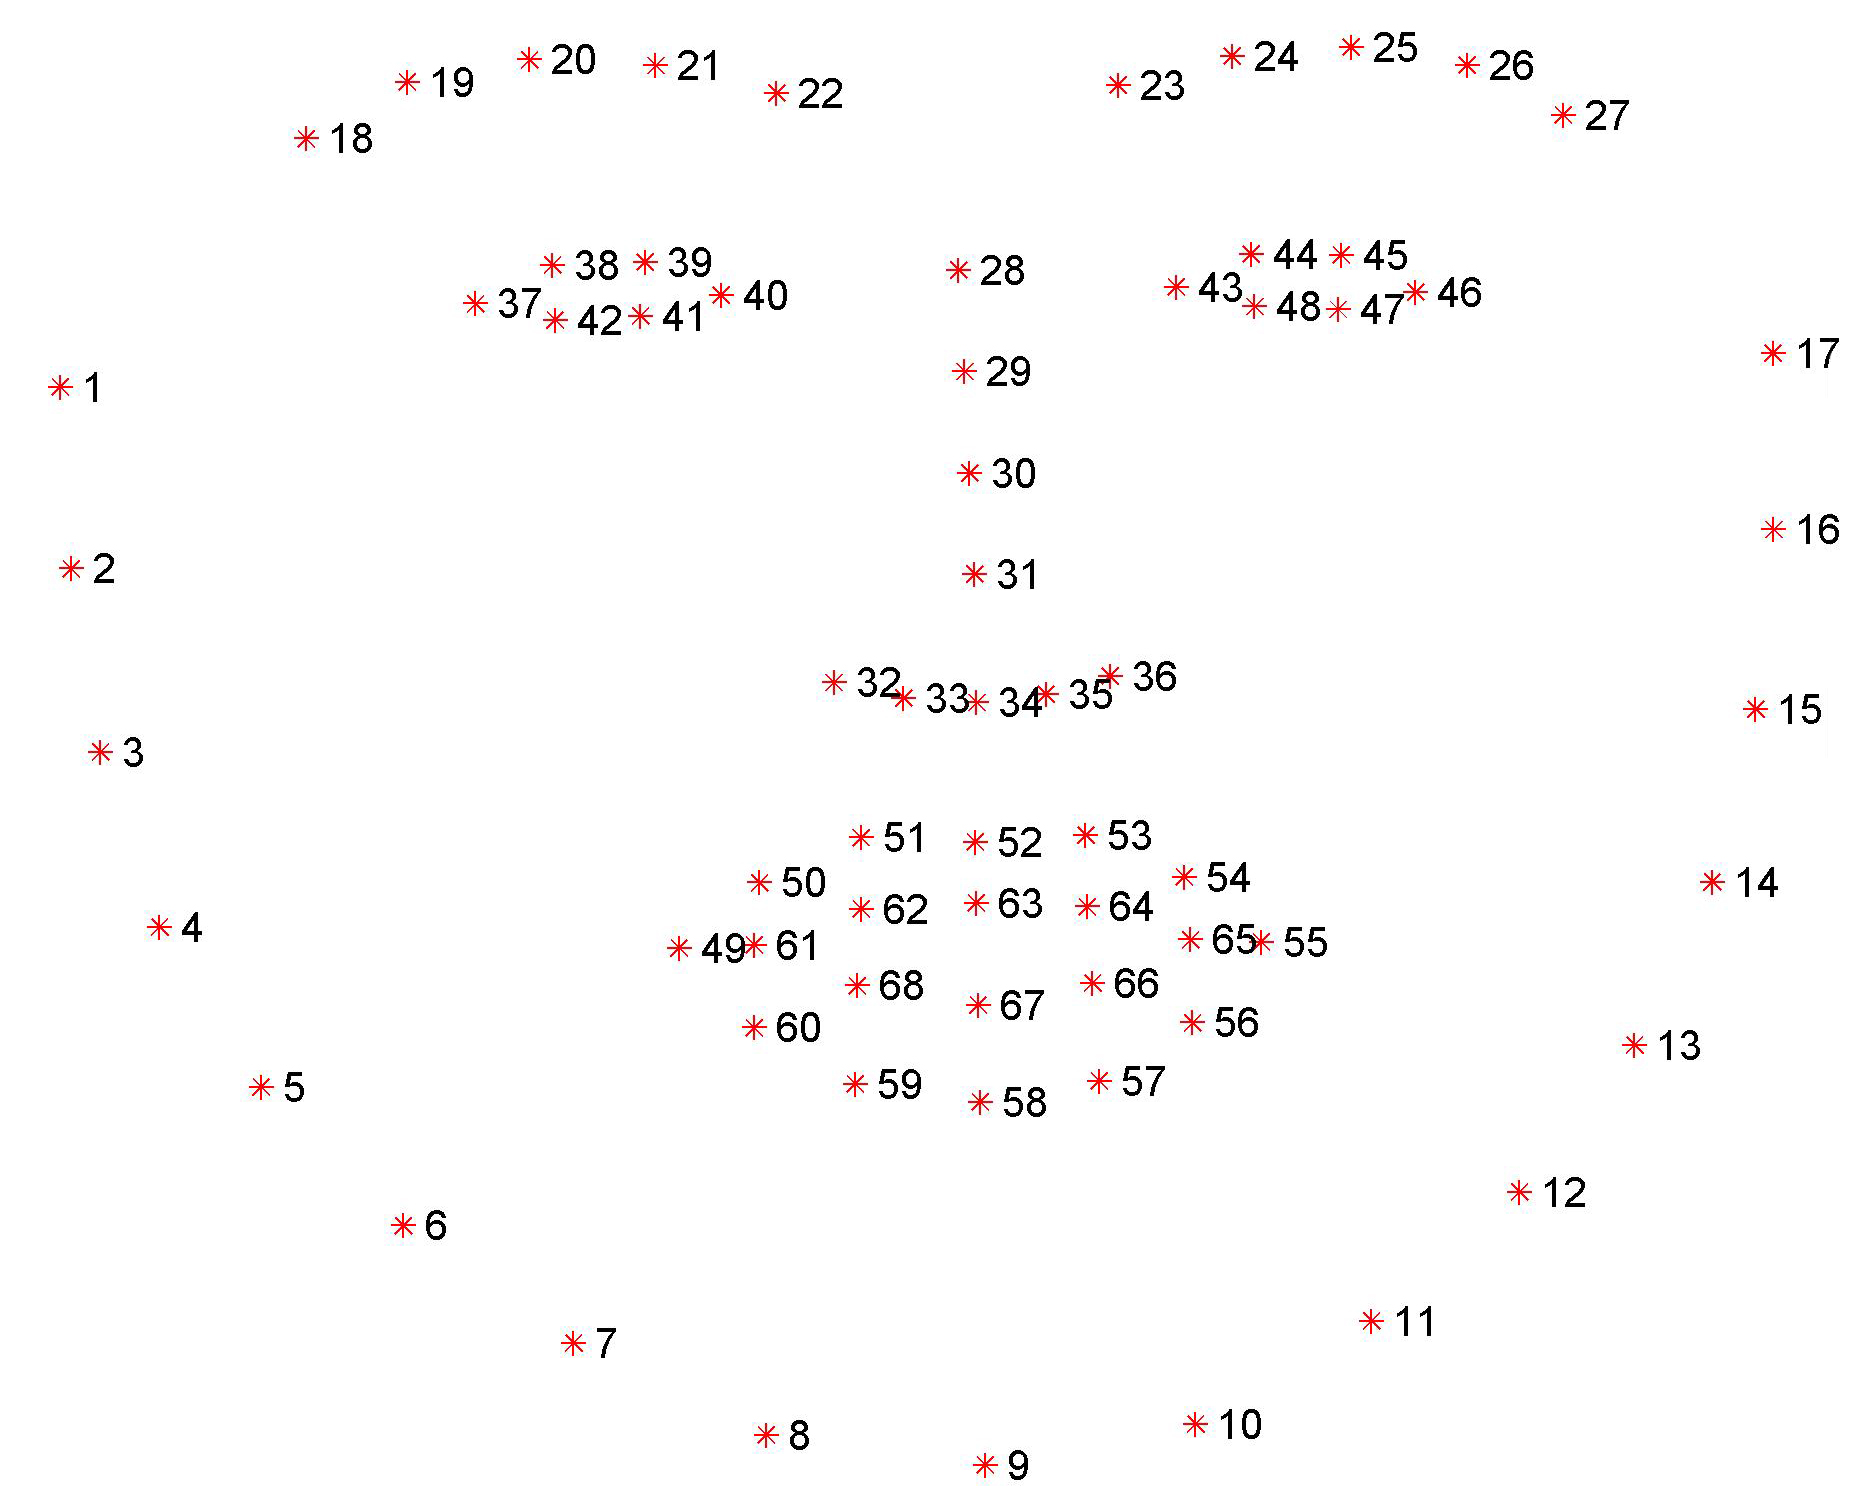

In [5]:
!curl -L https://huggingface.co/datasets/Gholamreza/facial-keypoints/resolve/main/train-test-data.zip --output train-test-data.zip
!unzip -n train-test-data.zip -d data
!rm train-test-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/test/Elmar_Brok_30.jpg  
  inflating: data/test/Elmar_Brok_31.jpg  
  inflating: data/test/Elsa_Zylberstein_00.jpg  
  inflating: data/test/Elsa_Zylberstein_01.jpg  
  inflating: data/test/Elsa_Zylberstein_10.jpg  
  inflating: data/test/Elsa_Zylberstein_11.jpg  
  inflating: data/test/Elsa_Zylberstein_40.jpg  
  inflating: data/test/Elsa_Zylberstein_41.jpg  
  inflating: data/test/Elton_John_10.jpg  
  inflating: data/test/Elton_John_11.jpg  
  inflating: data/test/Elton_John_20.jpg  
  inflating: data/test/Elton_John_21.jpg  
  inflating: data/test/Elton_John_30.jpg  
  inflating: data/test/Elton_John_31.jpg  
  inflating: data/test/Elton_John_40.jpg  
  inflating: data/test/Elton_John_41.jpg  
  inflating: data/test/Emile_Lahoud_00.jpg  
  inflating: data/test/Emile_Lahoud_01.jpg  
  inflating: data/test/Emile_Lahoud_30.jpg  
  inflating: data/test/Emile_Lahoud_31.jpg  
  inflating: data/test/Emile_Lahoud_40.jpg  


## Dataset and DataLoader

In [70]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, images_root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_root_dir = images_root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_root_dir, self.data.iloc[idx, 0])
        image = Image.open(image_path)
        original_height, original_width = image.size

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(np.array(image))

        # if image is rgba convert to rgb
        if(image.shape[0] == 4): # 0 because B,W,H
            image = image[0:3,:,:]

        keypoints = torch.tensor(self.data.iloc[idx, 1:].astype('float32').values, dtype=torch.float32)

        # normalize keypoint positions
        keypoints = keypoints.reshape(-1, 2)
        keypoints = keypoints / torch.tensor([original_height, original_width])

        # flatten again
        keypoints = keypoints.flatten()

        # keypoints /= 100.0

        return image, keypoints

In [71]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [122]:
train_dataset = FacialKeypointsDataset(csv_file="data/training_frames_keypoints.csv", images_root_dir="data/training", transform=transform)
test_dataset = FacialKeypointsDataset(csv_file="data/test_frames_keypoints.csv", images_root_dir="data/test", transform=transform)

In [123]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 3462
Number of test samples: 770


In [124]:
# create a subset of the dataset
DATASET_LENGTH = 100000
train_dataset = torch.utils.data.Subset(train_dataset, range(min(len(train_dataset), DATASET_LENGTH)))
test_dataset = torch.utils.data.Subset(test_dataset, range(min(len(test_dataset), DATASET_LENGTH)))

In [125]:
print(f"Number of selected training samples: {len(train_dataset)}")
print(f"Number of selected test samples: {len(test_dataset)}")

Number of selected training samples: 3462
Number of selected test samples: 770


In [126]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### a few samples

In [127]:
# a function to display the keypoints on top of the image
def show_keypoints(image, keypoints, figsize=(2,2)):
    plt.figure(figsize=figsize)
    plt.tight_layout()
    plt.imshow(image.permute(1, 2, 0))
    keypoints = keypoints.reshape((-1, 2))
    keypoints = keypoints * 224
    keypoints = keypoints.to(torch.int32)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, marker='.', c='g')
    plt.axis('off')
    plt.show()

In [128]:
image, keypoints = next(iter(train_dataloader))
keypoints.min().item(), keypoints.max().item()

(0.15094339847564697, 0.834645688533783)

In [129]:
image.shape, keypoints.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 136]))

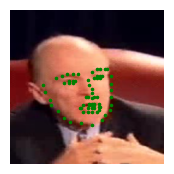

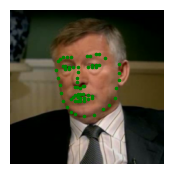

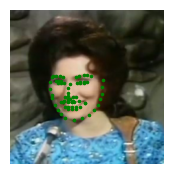

In [130]:
idx = 3
show_keypoints(image[idx], keypoints[idx])
idx = 4
show_keypoints(image[idx], keypoints[idx])
idx = 5
show_keypoints(image[idx], keypoints[idx])

## Model

In [131]:
class Model_Pretrained_CNN_MLP(nn.Module):
    def __init__(self, head_hidden_size=512, dropout_rate=0.3):
        super(Model_Pretrained_CNN_MLP, self).__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        backbone_clf_in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.dropout_rate = dropout_rate

        backbone_output_size = backbone_clf_in_features
        head_hidden_size = head_hidden_size
        output_size = 136 # 68 points with 2 coordinates each

        self.head = nn.Sequential(
            nn.Linear(backbone_output_size, head_hidden_size),
            # nn.BatchNorm1d(head_hidden_size),
            nn.ReLU(),
            # nn.Dropout(self.dropout_rate),
            nn.Linear(head_hidden_size, output_size)
        )

    def forward(self, x):
        # import pdb; pdb.set_trace()
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

In [133]:
model = Model_Pretrained_CNN_MLP(head_hidden_size=1024).to(device)

# freeze the backbone
for param in model.backbone.parameters():
    param.requires_grad = False

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

## Training

In [134]:
from tqdm.auto import tqdm

def train(model, train_loader, optimizer, criterion, running_loss, epoch):
    loss_history = []
    model.train()

    i = 0
    for (X, y) in (pbar := tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 136)) # 68 keypoints * 2
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * BATCH_SIZE

        loss_history.append(running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE))
        pbar.set_description(f"Batch {i}/{len(train_loader)} Loss: {running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE)}")

        # if i%5 == 0:
            # visualize_prediction(model, test_dataset[0])
            # plt.show()

        i += 1

    return running_loss,  loss_history

def train_1_batch(model, train_loader, optimizer, criterion, running_loss, epoch):
    loss_history = []
    model.train()

    X, y = next(iter(train_loader))

    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y.view(-1, 136)) # 68 keypoints * 2
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * BATCH_SIZE

    # loss_history.append(running_loss/(((epoch)*len(train_loader)+(i+1))*BATCH_SIZE))

    # if i%5 == 0:
        # visualize_prediction(model, test_dataset[0])
        # plt.show()


    return running_loss,  loss_history

def evaluate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    for i, (X, y) in enumerate(valid_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y.view(-1, 136))
        running_loss += loss.item()
    return running_loss / len(valid_loader)


def predict(model, sample):
    X, y = sample
    model.eval()
    with torch.no_grad():
        y_pred = model(X.unsqueeze(0).to(device))
    return y_pred.cpu()

def visualize_prediction(model, sample):
    X, y = sample
    y_pred = predict(model, sample)
    show_keypoints(X, y_pred[0])


### Start Training

#### Step 1) Overfit on 1 batch

In [111]:
model = Model_Pretrained_CNN_MLP(head_hidden_size=512).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 30

Epoch 1/30
train_loss: 0.041730987174170356 | Valid Loss: 0.0000

Epoch 2/30
train_loss: 0.033813495721135824 | Valid Loss: 0.0000

Epoch 3/30
train_loss: 0.02619634462254388 | Valid Loss: 0.0000

Epoch 4/30
train_loss: 0.02482503785618714 | Valid Loss: 0.0000

Epoch 5/30
train_loss: 0.0220774524978229 | Valid Loss: 0.0000

Epoch 6/30
train_loss: 0.020537117230040685 | Valid Loss: 0.0000

Epoch 7/30
train_loss: 0.01874203729082127 | Valid Loss: 0.0000

Epoch 8/30
train_loss: 0.017999425730002776 | Valid Loss: 0.0000

Epoch 9/30
train_loss: 0.01722131356123894 | Valid Loss: 0.0000

Epoch 10/30
train_loss: 0.016841841329421316 | Valid Loss: 0.0000

Epoch 11/30
train_loss: 0.016448295590552418 | Valid Loss: 0.0000

Epoch 12/30
train_loss: 0.015907836235350088 | Valid Loss: 0.0000

Epoch 13/30
train_loss: 0.015439981410464088 | Valid Loss: 0.0000

Epoch 14/30
train_loss: 0.015089436415202764 | Valid Loss: 0.0000

Epoch 15/30
train_loss: 0.014470512561854863 | Valid Loss: 0.0000

Epoch 16/3

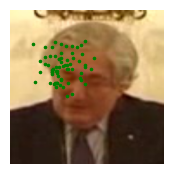

In [112]:
loss_history_global = []
train_loss = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss, history = train_1_batch(model, train_dataloader, optimizer, criterion, train_loss, epoch)
    # valid_loss = evaluate(model, test_dataloader, criterion)
    valid_loss = 0
    loss_history_global = loss_history_global + history
    print(f"train_loss: {train_loss/((epoch+1)*len(train_dataloader)*BATCH_SIZE)} | Valid Loss: {valid_loss:.4f}")
    print()
    plt.show()
visualize_prediction(model, test_dataset[0])

YES! Overfits!

#### Step 2) Actual Training

In [135]:
model = Model_Pretrained_CNN_MLP(head_hidden_size=1024).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_epochs = 20

In [ ]:
loss_history_global = []
train_loss = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    train_loss, history = train(model, train_dataloader, optimizer, criterion, train_loss, epoch)
    valid_loss = evaluate(model, test_dataloader, criterion)
    loss_history_global = loss_history_global + history
    print(f"train_loss: {train_loss/((epoch+1)*len(train_dataloader)*BATCH_SIZE)} | Valid Loss: {valid_loss:.4f}")
    visualize_prediction(model, test_dataset[0])
    plt.show()
    print()
    print()

Epoch 1/20


  0%|          | 0/217 [00:00<?, ?it/s]

In [ ]:
plt.plot(loss_history_global)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()